### Import libraries and data

In [37]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [38]:
# Load in the San Diego Police 'calls for service' dataset for 2022
calls_for_service_df = pd.read_csv(r'https://seshat.datasd.org/pd/pd_calls_for_service_2022_datasd.csv')

# Load in supporting tables
#pd_dict_df = pd.read_csv(r'https://seshat.datasd.org/pd/pd_calls_for_service_dictionary_datasd.csv')
call_type_code_df = pd.read_csv(r'https://seshat.datasd.org/pd/pd_cfs_calltypes_datasd.csv')
disposition_code_df = pd.read_csv(r'http://seshat.datasd.org/pd/pd_dispo_codes_datasd.csv')
beat_code_df = pd.read_csv(r'https://seshat.datasd.org/pd/pd_beat_codes_list_datasd.csv')

### Preview subset of data

In [39]:
calls_for_service_df.head()

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E22010000001,2022-01-01 00:00:00,7,1300,NaN,MORAEA,ST,NaN,NaN,NaN,AU1,DUP,452,1
1,E22010000002,2022-01-01 00:00:07,7,600,NaN,BROADWAY,NaN,NaN,NaN,NaN,1186,CAN,524,3
2,E22010000003,2022-01-01 00:00:08,7,700,NaN,GRAND,AVE,NaN,NaN,NaN,1186,K,122,3
3,E22010000004,2022-01-01 00:00:15,7,4600,NaN,AIR,WAY,NaN,NaN,NaN,MPSSTP,K,447,2
4,E22010000005,2022-01-01 00:00:22,7,4700,NaN,MISSION BAY,DR,NaN,NaN,NaN,AU1,DUP,122,1


In [40]:
call_type_code_df.head()

,call_type,description,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,1016,PRISONER IN CUSTODY,NaN,NaN,NaN
1,1016PT,PTU (PRISONER TRANSPORT),NaN,NaN,NaN
2,1016QC,SHOPLIFTER/QUICK CITE,NaN,NaN,NaN
3,1021,PHONE YOUR STATION,NaN,NaN,NaN
4,1021H,PHONE YOUR HOME,NaN,NaN,NaN


Notice here in that there are 3 columns without any label in this .csv. Let's check for values:

In [41]:
print(call_type_code_df['Unnamed: 2'].unique())
print(call_type_code_df['Unnamed: 3'].unique())
print(call_type_code_df['Unnamed: 4'].unique())

[nan]
[nan]
[nan 'U']


There are no non-null values for Unnamed 2 and Unnamed 3. Unnamed 4 is either null or 'U'.

In [42]:
call_code_df = call_type_code_df[call_type_code_df['Unnamed: 4'] == 'U']
call_code_df

,call_type,description,Unnamed: 2,Unnamed: 3,Unnamed: 4
204,CCF,CITIZEN'S COMPLAINT INVESTIGAT,NaN,NaN,U


This value corresponds to a call type of "CITIZEN'S COMPLAINT INVESTIGAT". This may denote an internal investigation. We'll leave that column in the table.

In [43]:
call_code_df = call_type_code_df[['call_type', 'description', 'Unnamed: 4']]
#call_code_df

In [44]:
disposition_code_df.head()

,dispo_code,description
0,X,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...
1,A,ARREST MADE
2,AB,"ARREST MADE, BOARD AND SECURE"
3,AHR,"ARREST MADE, HIGH RISK (CRISIS RESPONSE TEAM)"
4,R,REPORT


In [45]:
beat_code_df.head()

,beat,neighborhood
0,111,Clairemont Mesa East
1,112,Clairemont Mesa West
2,113,Bay Ho
3,114,North Clairemont
4,115,University City


## Clean Data:

##### Initial data statistics:


Eliminate duplicates and records without any primary key

In [46]:
## Check if any rows are missing a primary key value or date
calls_for_service_df['incident_num'].isnull().values.any() | calls_for_service_df['date_time'].isnull().values.any()

False

In [47]:
# Get initial counts of records in calls_for_service_df:
print(calls_for_service_df.count())

incident_num                 247348
date_time                    247348
day_of_week                  247348
address_number_primary       247348
address_dir_primary           11438
address_road_primary         247315
address_sfx_primary          225453
address_dir_intersecting          0
address_road_intersecting     42226
address_sfx_intersecting          0
call_type                    247023
disposition                  246166
beat                         247348
priority                     247348
dtype: int64


We can see in the above count that there are ssigned a call type (classified as 'NaN'). Any records without a proper call type will possibly skew category percentages if they are taken out of total number of records. Similarly, records without a disposition or beat will also affect figures if those nulls are not excluded. The data is still useful, however, so we'll create a seperate dataframe to exclude those records for now:

In [48]:
# Remove any records with a null call_type, disposition, or beat
calls_df = calls_for_service_df.dropna(subset=['call_type', 'disposition', 'beat'])

# Drop any duplicate records while we're at it
calls_df.drop_duplicates()
print('Number of records excluded: ', len(calls_for_service_df) - len(calls_df))

Number of records excluded:  1506


There are a number of call types I'll chose to filter out. Namely, duplicate calls (with a disposition of DUP or V ) as well as certain 10-codes (10-21 phone your station, 10-21H phone your home, 10-22, disregard)

In [49]:
calls_df2 = calls_df[(calls_df.disposition != 'DUP') & (calls_df.disposition != 'V')]
print('Number of duplicate records filtered: ', len(calls_df) - len(calls_df2))

calls_df3 = calls_df2[(calls_df2.call_type != '1021') & (calls_df2.call_type != '1021H') & (calls_df2.call_type != '1022')]
print('Number of records filtered by call type: ', len(calls_df2) - len(calls_df3))

Number of duplicate records filtered:  4372
Number of records filtered by call type:  2327


Now that we've decreased the number of records a good bit, now is a good time to join the data definition tables to our main calls dataset. 

In [50]:
# Join calls with descriptions of calls on call code (Police 10 codes)
calls_df4 = pd.merge(calls_df3,
                    call_code_df,
                    left_on='call_type',
                    right_on='call_type',
                    how='left')

# Join calls with dispositions (outcomes) on disposition code
calls_df4_join = pd.merge(calls_df4,
                     disposition_code_df,
                     left_on='disposition',
                     right_on='dispo_code',
                     how='left',
                     suffixes=(None, '_disposition'))

# Join calls with beat locations on beat number
calls_df5 = pd.merge(calls_df4_join,
                    beat_code_df,
                    left_on='beat',
                    right_on='beat',
                    how='left')

In [51]:
calls_df5.columns

Index(['incident_num', 'date_time', 'day_of_week', 'address_number_primary',
       'address_dir_primary', 'address_road_primary', 'address_sfx_primary',
       'address_dir_intersecting', 'address_road_intersecting',
       'address_sfx_intersecting', 'call_type', 'disposition', 'beat',
       'priority', 'description', 'Unnamed: 4', 'dispo_code',
       'description_disposition', 'neighborhood'],
      dtype='object')

## Analysis of data

#### Top 15 Categories of calls for service from SDPD

In [52]:
# Show the top 10 categories of calls for service
calls_df5['description'].value_counts().head(15)

DISTURBING PEACE                         42294
CHECK THE WELFARE                        11797
SELECTIVE ENFORCEMENT                    11438
BURGLARY ALARM                           11062
TRAFFIC STOP WITH PLATE                  10890
ILLEGAL PARKING                           8066
DISTURBING PEACE W/VIOLENCE               7418
SPECIAL DETAIL                            7160
MENTAL CASE                               6641
TRAFFIC STOP FROM THE MOBILE COMPUTER     6142
UNK EMERG, HANG UP/OPEN LINE              5152
IN A MEETING/OUT OF SERVICE               4377
FOLLOW-UP BY FIELD UNIT                   4124
FLAG DOWN/FIELD INITIATED                 3960
NO DETAIL ACCIDENT                        3950
Name: description, dtype: int64

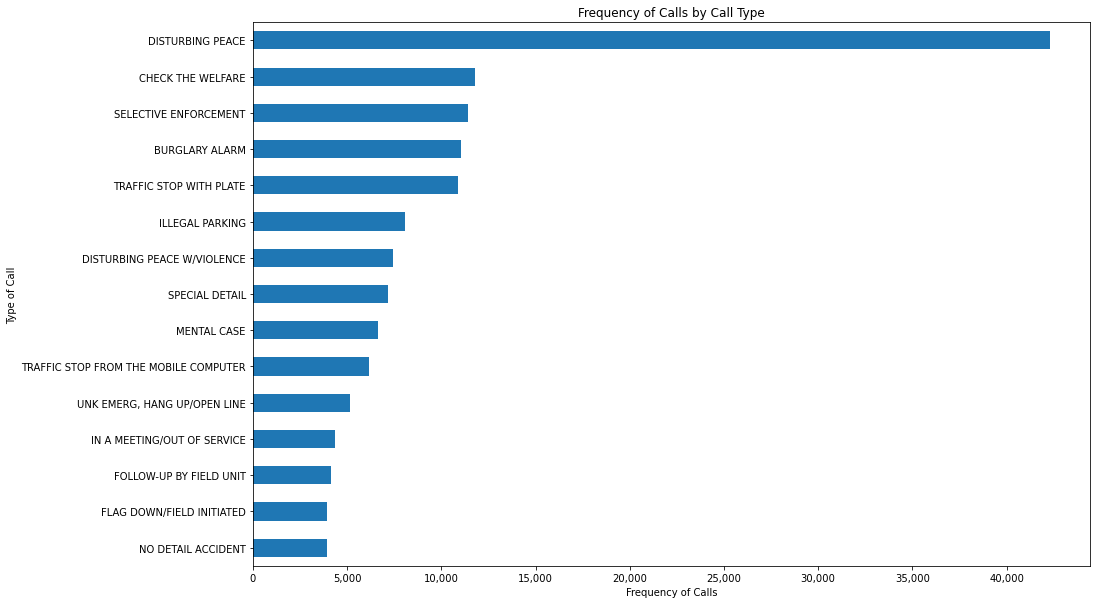

In [53]:
# Plot on graph
calls_df6 = calls_df5['description'].value_counts(ascending=True)

fig = plt.figure(figsize=(15, 10))
plt.title("Frequency of Calls by Call Type")
plt.xlabel("Frequency of Calls")
plt.ylabel("Type of Call")
ax = calls_df6.tail(15).plot(kind='barh')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.savefig("TypeOfCall.png")

#### What usually happens once SDPD responds?

In [54]:
calls_df5['description_disposition'].value_counts()

NO REPORT REQUIRED                                              144313
OTHER                                                            35854
REPORT                                                           23422
CANCEL                                                           22739
NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISPATCHING A UNIT     18261
ARREST MADE                                                      10348
UNFOUNDED                                                         6450
STOLEN VEHICLE OR RECOVERED VEHICLE                                504
DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ONSCENE                485
NO FURTHER ACTION, HIGH RISK (CRISIS RESPONSE TEAM)                 15
OTHER, HIGH RISK (CRISIS RESPONSE TEAM)                             15
NO REPORT REQUIRED, BOARD AND SECURE                                13
ARREST MADE, BOARD AND SECURE                                        2
REPORT TAKEN, BOARD AND SECURE                                       2
REPORT

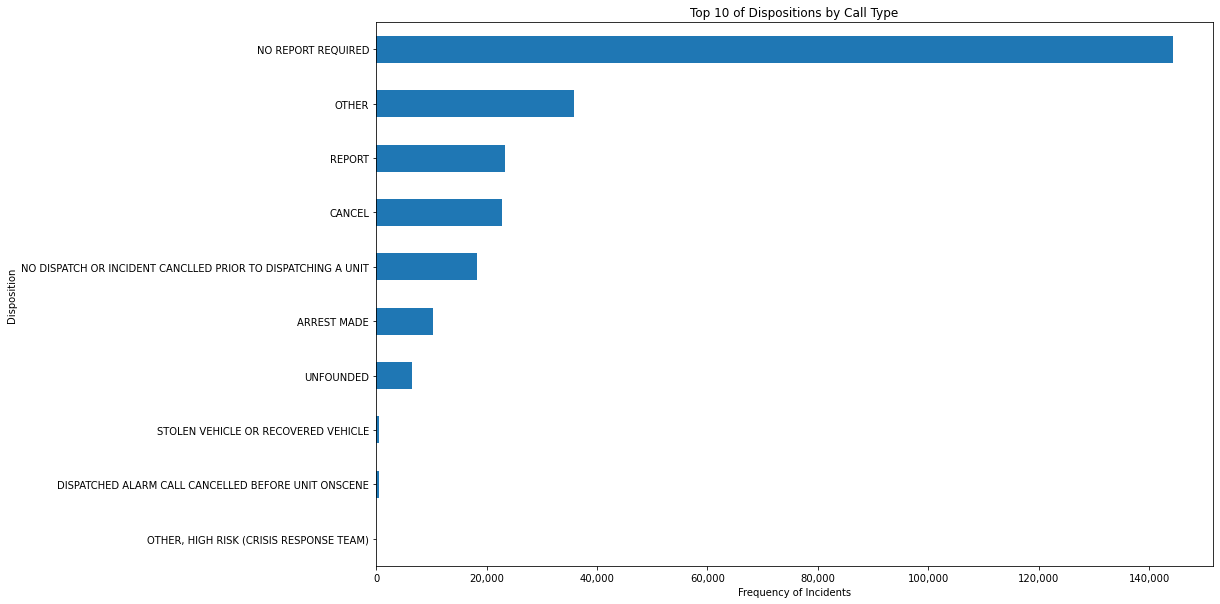

In [55]:
calls_dispo_outcome = calls_df5['description_disposition'].value_counts(ascending=True)
top_ten = calls_dispo_outcome.tail(10)
fig = plt.figure(figsize=(15, 10))
plt.title("Top 10 of Dispositions by Call Type")
plt.xlabel("Frequency of Incidents")
plt.ylabel("Disposition")
ax = top_ten.plot(kind='barh')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.savefig("TypeOfDispo.png")

#### What percentage of incidents resulted in arrest?

In [56]:
calls_df_arrests = calls_df5[(calls_df5.description_disposition == 'ARREST MADE') | (calls_df5.description_disposition == 'ARREST MADE, BOARD AND SECURE')]
print("Number of arrests: ", len(calls_df_arrests))
print("Number of calls: ", len(calls_df5))
arrest_percent = len(calls_df_arrests)/len(calls_df5) * 100
print("Percent of incidents that end in arrest: ", arrest_percent)

Number of arrests:  10350
Number of calls:  262445
Percent of incidents that end in arrest:  3.9436834384347197


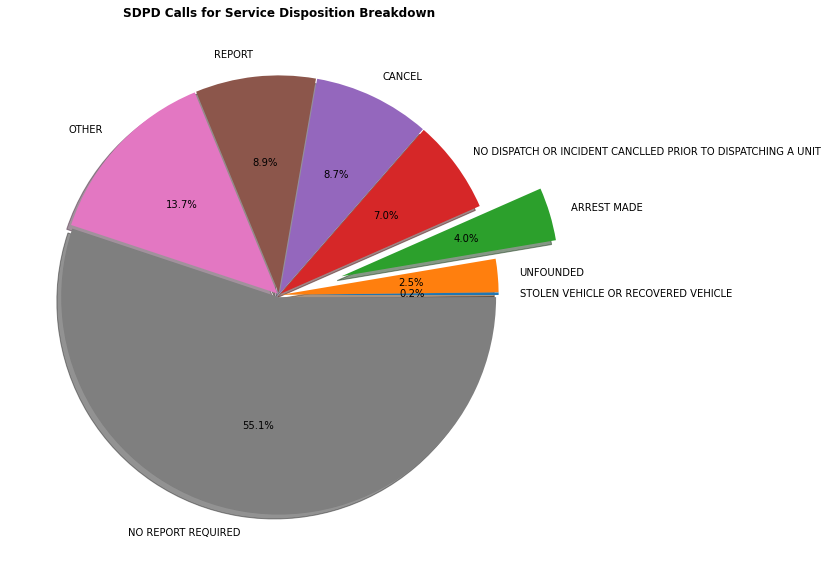

In [57]:
# Display percentage of arrests made
top_eight = calls_dispo_outcome.tail(8)

def convertToPercent(x):
        return x/len(calls_df5) * 100

labels = top_eight.axes[0]
sizes = top_eight.values

for i in sizes:
        i = convertToPercent(i)

plt.figure(figsize=(10,10))
explode = (0.01, 0.01, 0.3, 0.01, 0.01, 0.01, 0.01, 0.01)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%.1f%%')
plt.title('SDPD Calls for Service Disposition Breakdown',fontweight='bold')

plt.show()

##### How many calls for service within each neighborhood?

In [58]:
calls_df5['neighborhood'].value_counts()

East Village            12867
Pacific Beach            9410
Core-Columbia            8820
North Park               7016
Midway District          6801
                        ...  
Qualcomm                   96
Islenair                   86
Tijuana River Valley       75
Burlingame                 68
Broadway Heights           64
Name: neighborhood, Length: 125, dtype: int64

In [59]:
# Map of neighborhood beats
#Image(filename='datasets/neighborhoods.png', width=900) 

Each beat belongs to a division. The first digit of a beat indicates its division.

In [60]:
districts = [[1, "Northern"], [2, "Northeastern"], [3, "Eastern"], [4, "Southeastern"], [5, "Central"], [6, "Western"], [7, "Southern"], [8, "Mid City"], [9, "Northwestern"]]
district_df = pd.DataFrame(districts, columns=['division_prefix', 'district'])
district_df

,division_prefix,district
0,1,Northern
1,2,Northeastern
2,3,Eastern
3,4,Southeastern
4,5,Central
5,6,Western
6,7,Southern
7,8,Mid City
8,9,Northwestern


Add a division column to each call record

In [61]:
calls_df5['division_prefix'] = calls_df5.apply(lambda row: row.beat/100, axis=1)
calls_df5['division_prefix'] = calls_df5['division_prefix'].astype(int)

calls_df6 = pd.merge(calls_df5,
                    district_df,
                    left_on='division_prefix',
                    right_on='division_prefix',
                    how='left')

calls_df6['district'].value_counts()

Central         55148
Western         37576
Northern        35788
Mid City        33618
Eastern         28029
Southeastern    23579
Southern        17282
Northeastern    16917
Northwestern    11146
Name: district, dtype: int64

In [62]:
calls_df6.to_csv('out.csv')